## Hyperparameter Tuning

- How to decide the architecture of a Neural Net? epoch? batch size=? learning rate = ? => experiment on various paramters
eg: grid_search, random_search, Bayesian search(using Optuna)

### sample code

def objective(trial):
    param1 = trial.suggest_int('param1', x1, x2)
    ....

    model = Model(param1, param2, ....)

    accuracy = function(model(test_data))

    return accuracy

study = optuna.create_study(direction = 'maximize', sampler=optuna.samplers.TPEsampler())
study.optimize(objective, n_trials = n)

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time
from optuna import create_study

e:\Python_Virtual_Environments\torch_learn_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data_path = r"E:\AbioticNeuron\DS\Pytorch\fmnist_problem\dataset\fashion-mnist_train.csv"
test_data_path = r"E:\AbioticNeuron\DS\Pytorch\fmnist_problem\dataset\fashion-mnist_test.csv"
x_dtype = torch.float32
y_dtype = torch.long
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# torch.device('cpu') 
print(device)
learning_rate = 0.1
epochs = 100

cuda


## Data Preparation

In [3]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
train_data_x = train_data.iloc[:, 1:]/255.0
train_data_y = train_data.iloc[:,0]

test_data_x = test_data.iloc[:, 1:]/255.0
test_data_y = test_data.iloc[:,0]

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, input_x, input_y, device):
        super().__init__()
        # Convert to tensors and move to device once
        self.x = torch.tensor(input_x.values, dtype=x_dtype, device=device)
        self.y = torch.tensor(input_y.values, dtype=y_dtype, device=device)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [6]:
train_dataset = FMNISTDataset(train_data_x, train_data_y, device)
test_dataset = FMNISTDataset(test_data_x, test_data_y, device)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

## Modified Model Architecture

In [7]:
class NNModel(torch.nn.Module):
    def __init__(self, num_features, num_outputs, num_hidden_layers, neurons_per_layer, dropout_rate):
        super().__init__()

        layers = []

        for i in range(num_hidden_layers):
            layer = nn.Linear(num_features, neurons_per_layer)
            layers.append(layer)
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_rate))
            num_features = neurons_per_layer
        
        layers.append(nn.Linear(neurons_per_layer, num_outputs))
        self.neural_network = nn.Sequential(*layers)


    def forward(self, x):
        return self.neural_network(x)

## Creating Optuna objective function

In [8]:
# creating objective function

def objective(trial):

    # hyper-parameter values
    num_hidden_layers = trial.suggest_int("num_hidden_layer", 1, 5)
    num_neurons = trial.suggest_int("num_neurons", 8, 128, step=8)
    epochs = trial.suggest_int("epochs", 30, 100, step=10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step = 0.1)
    batch_size = trial.suggest_categorical("batch_size",[16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer_name", ['SGD', 'Adam', 'RMSprop'])
    lambda_val = trial.suggest_float('lambda_val', 1e-5, 1e-3, log=True)

    # initialize the model
    input_dim = 784
    output_dim = 10
    model = NNModel(input_dim, output_dim, num_hidden_layers, num_neurons,dropout_rate)
    model.to(device)

    # parameter values
    l_r = 0.1
    lambda_val = 1e-4 

    # initialize loss function
    loss_function = nn.CrossEntropyLoss()

    # initialize optimizer
    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(params=model.neural_network.parameters(), lr=learning_rate, weight_decay=lambda_val)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(params=model.neural_network.parameters(), lr=learning_rate, weight_decay=lambda_val)
    else:
        optimizer = torch.optim.RMSprop(params=model.neural_network.parameters(), lr=learning_rate, weight_decay=lambda_val)
    

    # creating dataloader objects
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

    # model training
    for epoch in range(epochs):
        for batch_idx, (features, label) in enumerate(train_data_loader):
            
            prediction = model(features)
            loss = loss_function(prediction, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    

    # compute accuracy
    model.eval()
    test_total = 0
    test_correct = 0

    with torch.no_grad():
        # Train data accuracy
        for x, y in test_data_loader:
            y_pred = model(x)                          
            predicted = torch.argmax(y_pred, dim=1)    
            test_total += y.size(0)
            test_correct += (predicted == y).sum().item()
    
    accuracy = test_correct/test_total
    return accuracy

## Creating Optuna Study

In [9]:
study = create_study(direction='maximize')
study.optimize(func=objective, n_trials=50, show_progress_bar=True)

[I 2025-08-12 19:47:29,753] A new study created in memory with name: no-name-a5dfed89-de94-4af6-85a6-e96d96938929
Best trial: 0. Best value: 0.8513:   2%|▏         | 1/50 [01:44<1:25:00, 104.09s/it]

[I 2025-08-12 19:49:13,851] Trial 0 finished with value: 0.8513 and parameters: {'num_hidden_layer': 1, 'num_neurons': 56, 'epochs': 60, 'learning_rate': 0.006202018789117363, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer_name': 'RMSprop', 'lambda_val': 0.00015501607935558014}. Best is trial 0 with value: 0.8513.


Best trial: 1. Best value: 0.8619:   4%|▍         | 2/50 [05:37<2:24:21, 180.44s/it]

[I 2025-08-12 19:53:07,732] Trial 1 finished with value: 0.8619 and parameters: {'num_hidden_layer': 2, 'num_neurons': 56, 'epochs': 100, 'learning_rate': 1.3607453607535487e-05, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer_name': 'RMSprop', 'lambda_val': 4.302953257579698e-05}. Best is trial 1 with value: 0.8619.


Best trial: 1. Best value: 0.8619:   6%|▌         | 3/50 [07:21<1:53:48, 145.30s/it]

[I 2025-08-12 19:54:51,209] Trial 2 finished with value: 0.858 and parameters: {'num_hidden_layer': 1, 'num_neurons': 24, 'epochs': 60, 'learning_rate': 2.7449227627951963e-05, 'dropout_rate': 0.4, 'batch_size': 128, 'optimizer_name': 'RMSprop', 'lambda_val': 6.751124896293365e-05}. Best is trial 1 with value: 0.8619.


Best trial: 3. Best value: 0.8629:   8%|▊         | 4/50 [12:00<2:31:43, 197.90s/it]

[I 2025-08-12 19:59:29,759] Trial 3 finished with value: 0.8629 and parameters: {'num_hidden_layer': 4, 'num_neurons': 56, 'epochs': 80, 'learning_rate': 0.002241881247067846, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 8.411314744203987e-05}. Best is trial 3 with value: 0.8629.


Best trial: 4. Best value: 0.8845:  10%|█         | 5/50 [15:26<2:30:43, 200.97s/it]

[I 2025-08-12 20:02:56,172] Trial 4 finished with value: 0.8845 and parameters: {'num_hidden_layer': 3, 'num_neurons': 80, 'epochs': 70, 'learning_rate': 0.002224577848320579, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer_name': 'Adam', 'lambda_val': 0.000207611255093678}. Best is trial 4 with value: 0.8845.


Best trial: 4. Best value: 0.8845:  12%|█▏        | 6/50 [20:46<2:56:57, 241.31s/it]

[I 2025-08-12 20:08:15,780] Trial 5 finished with value: 0.8466 and parameters: {'num_hidden_layer': 5, 'num_neurons': 80, 'epochs': 90, 'learning_rate': 0.00014314041714039855, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer_name': 'SGD', 'lambda_val': 0.00010203296096121624}. Best is trial 4 with value: 0.8845.


Best trial: 4. Best value: 0.8845:  14%|█▍        | 7/50 [22:26<2:20:03, 195.42s/it]

[I 2025-08-12 20:09:56,732] Trial 6 finished with value: 0.8566 and parameters: {'num_hidden_layer': 4, 'num_neurons': 80, 'epochs': 30, 'learning_rate': 5.964499650375114e-05, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer_name': 'RMSprop', 'lambda_val': 2.0538421330650984e-05}. Best is trial 4 with value: 0.8845.


Best trial: 7. Best value: 0.8945:  16%|█▌        | 8/50 [28:21<2:52:10, 245.96s/it]

[I 2025-08-12 20:15:50,900] Trial 7 finished with value: 0.8945 and parameters: {'num_hidden_layer': 5, 'num_neurons': 96, 'epochs': 100, 'learning_rate': 0.09749301749343761, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_name': 'SGD', 'lambda_val': 6.503853862182409e-05}. Best is trial 7 with value: 0.8945.


Best trial: 7. Best value: 0.8945:  18%|█▊        | 9/50 [30:57<2:28:57, 217.98s/it]

[I 2025-08-12 20:18:27,366] Trial 8 finished with value: 0.7473 and parameters: {'num_hidden_layer': 5, 'num_neurons': 56, 'epochs': 40, 'learning_rate': 0.024099447627071117, 'dropout_rate': 0.1, 'batch_size': 128, 'optimizer_name': 'RMSprop', 'lambda_val': 0.00031320203998465946}. Best is trial 7 with value: 0.8945.


Best trial: 7. Best value: 0.8945:  20%|██        | 10/50 [32:43<2:02:18, 183.45s/it]

[I 2025-08-12 20:20:13,500] Trial 9 finished with value: 0.8685 and parameters: {'num_hidden_layer': 5, 'num_neurons': 104, 'epochs': 30, 'learning_rate': 0.0016929140484773563, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'SGD', 'lambda_val': 0.00022451539546995437}. Best is trial 7 with value: 0.8945.


Best trial: 7. Best value: 0.8945:  22%|██▏       | 11/50 [36:54<2:12:36, 204.00s/it]

[I 2025-08-12 20:24:24,093] Trial 10 finished with value: 0.8831 and parameters: {'num_hidden_layer': 3, 'num_neurons': 128, 'epochs': 100, 'learning_rate': 0.09313541069011831, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer_name': 'SGD', 'lambda_val': 0.0006718840663133229}. Best is trial 7 with value: 0.8945.


Best trial: 11. Best value: 0.9029:  24%|██▍       | 12/50 [40:37<2:12:52, 209.80s/it]

[I 2025-08-12 20:28:07,166] Trial 11 finished with value: 0.9029 and parameters: {'num_hidden_layer': 3, 'num_neurons': 104, 'epochs': 80, 'learning_rate': 0.0003490575544504778, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 2.942984941396001e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  26%|██▌       | 13/50 [44:19<2:11:37, 213.45s/it]

[I 2025-08-12 20:31:48,994] Trial 12 finished with value: 0.8996 and parameters: {'num_hidden_layer': 3, 'num_neurons': 112, 'epochs': 80, 'learning_rate': 0.0003198259028517144, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.3047753707901537e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  28%|██▊       | 14/50 [47:19<2:02:06, 203.53s/it]

[I 2025-08-12 20:34:49,592] Trial 13 finished with value: 0.9011 and parameters: {'num_hidden_layer': 2, 'num_neurons': 128, 'epochs': 80, 'learning_rate': 0.0002859121383048617, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.2850440252109956e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  30%|███       | 15/50 [50:19<1:54:31, 196.34s/it]

[I 2025-08-12 20:37:49,283] Trial 14 finished with value: 0.8957 and parameters: {'num_hidden_layer': 2, 'num_neurons': 128, 'epochs': 80, 'learning_rate': 0.00041106656001092963, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 2.571492821580068e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  32%|███▏      | 16/50 [52:10<1:36:45, 170.75s/it]

[I 2025-08-12 20:39:40,598] Trial 15 finished with value: 0.898 and parameters: {'num_hidden_layer': 2, 'num_neurons': 112, 'epochs': 50, 'learning_rate': 0.00013170218782945444, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer_name': 'Adam', 'lambda_val': 1.3945194890968243e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  34%|███▍      | 17/50 [54:50<1:32:03, 167.39s/it]

[I 2025-08-12 20:42:20,172] Trial 16 finished with value: 0.9007 and parameters: {'num_hidden_layer': 2, 'num_neurons': 128, 'epochs': 70, 'learning_rate': 0.0005576664256627687, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 3.1945429858404534e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  36%|███▌      | 18/50 [59:47<1:50:07, 206.47s/it]

[I 2025-08-12 20:47:17,635] Trial 17 finished with value: 0.8283 and parameters: {'num_hidden_layer': 4, 'num_neurons': 96, 'epochs': 90, 'learning_rate': 0.00937496265284193, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.066550325929186e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  38%|███▊      | 19/50 [1:02:24<1:38:57, 191.52s/it]

[I 2025-08-12 20:49:54,320] Trial 18 finished with value: 0.8351 and parameters: {'num_hidden_layer': 1, 'num_neurons': 8, 'epochs': 90, 'learning_rate': 0.00012370458108282114, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 3.790703283526208e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  40%|████      | 20/50 [1:05:01<1:30:29, 181.00s/it]

[I 2025-08-12 20:52:30,797] Trial 19 finished with value: 0.8946 and parameters: {'num_hidden_layer': 2, 'num_neurons': 112, 'epochs': 70, 'learning_rate': 0.0010786332633825218, 'dropout_rate': 0.4, 'batch_size': 32, 'optimizer_name': 'Adam', 'lambda_val': 1.868890745711701e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  42%|████▏     | 21/50 [1:08:41<1:33:13, 192.86s/it]

[I 2025-08-12 20:56:11,327] Trial 20 finished with value: 0.8972 and parameters: {'num_hidden_layer': 3, 'num_neurons': 96, 'epochs': 80, 'learning_rate': 5.174558855144817e-05, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer_name': 'Adam', 'lambda_val': 4.5330596497772354e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  44%|████▍     | 22/50 [1:11:21<1:25:19, 182.84s/it]

[I 2025-08-12 20:58:50,776] Trial 21 finished with value: 0.8968 and parameters: {'num_hidden_layer': 2, 'num_neurons': 128, 'epochs': 70, 'learning_rate': 0.0005278278390612706, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 3.0874324522355795e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  46%|████▌     | 23/50 [1:13:36<1:15:53, 168.65s/it]

[I 2025-08-12 21:01:06,332] Trial 22 finished with value: 0.895 and parameters: {'num_hidden_layer': 2, 'num_neurons': 120, 'epochs': 60, 'learning_rate': 0.0005605666908785409, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 2.1159960947652812e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  48%|████▊     | 24/50 [1:16:55<1:16:57, 177.61s/it]

[I 2025-08-12 21:04:24,838] Trial 23 finished with value: 0.8986 and parameters: {'num_hidden_layer': 3, 'num_neurons': 120, 'epochs': 70, 'learning_rate': 0.0002682668892293311, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.4024658365021317e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  50%|█████     | 25/50 [1:18:25<1:03:08, 151.53s/it]

[I 2025-08-12 21:05:55,508] Trial 24 finished with value: 0.8701 and parameters: {'num_hidden_layer': 1, 'num_neurons': 104, 'epochs': 50, 'learning_rate': 0.004866484298475381, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 2.997088758626967e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  52%|█████▏    | 26/50 [1:22:41<1:13:05, 182.74s/it]

[I 2025-08-12 21:10:11,093] Trial 25 finished with value: 0.8971 and parameters: {'num_hidden_layer': 3, 'num_neurons': 128, 'epochs': 90, 'learning_rate': 0.0009411563448367761, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.0213924481727965e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  54%|█████▍    | 27/50 [1:25:45<1:10:11, 183.11s/it]

[I 2025-08-12 21:13:15,054] Trial 26 finished with value: 0.9001 and parameters: {'num_hidden_layer': 2, 'num_neurons': 120, 'epochs': 80, 'learning_rate': 0.00019841330771687386, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.8305489745909437e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  56%|█████▌    | 28/50 [1:28:30<1:05:12, 177.86s/it]

[I 2025-08-12 21:16:00,659] Trial 27 finished with value: 0.894 and parameters: {'num_hidden_layer': 4, 'num_neurons': 88, 'epochs': 50, 'learning_rate': 6.323231318217099e-05, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 5.3498739742825184e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  58%|█████▊    | 29/50 [1:31:18<1:01:12, 174.86s/it]

[I 2025-08-12 21:18:48,534] Trial 28 finished with value: 0.899 and parameters: {'num_hidden_layer': 2, 'num_neurons': 104, 'epochs': 70, 'learning_rate': 0.0008375818475221355, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer_name': 'Adam', 'lambda_val': 0.00011440640478264073}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  60%|██████    | 30/50 [1:32:54<50:22, 151.13s/it]  

[I 2025-08-12 21:20:24,296] Trial 29 finished with value: 0.8792 and parameters: {'num_hidden_layer': 1, 'num_neurons': 40, 'epochs': 60, 'learning_rate': 0.007570360070282337, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer_name': 'SGD', 'lambda_val': 3.216555081625606e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  62%|██████▏   | 31/50 [1:37:08<57:35, 181.88s/it]

[I 2025-08-12 21:24:37,920] Trial 30 finished with value: 0.8779 and parameters: {'num_hidden_layer': 3, 'num_neurons': 72, 'epochs': 80, 'learning_rate': 0.00411105997589014, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 2.407862517235999e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  64%|██████▍   | 32/50 [1:43:15<1:11:14, 237.48s/it]

[I 2025-08-12 21:30:45,114] Trial 31 finished with value: 0.9016 and parameters: {'num_hidden_layer': 2, 'num_neurons': 120, 'epochs': 80, 'learning_rate': 0.0002367096184294623, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.7518865980197403e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  66%|██████▌   | 33/50 [1:49:47<1:20:26, 283.89s/it]

[I 2025-08-12 21:37:17,306] Trial 32 finished with value: 0.9004 and parameters: {'num_hidden_layer': 2, 'num_neurons': 120, 'epochs': 90, 'learning_rate': 0.0002445183137402965, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.6430670864777586e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  68%|██████▊   | 34/50 [1:54:07<1:13:45, 276.59s/it]

[I 2025-08-12 21:41:36,871] Trial 33 finished with value: 0.8823 and parameters: {'num_hidden_layer': 1, 'num_neurons': 112, 'epochs': 80, 'learning_rate': 1.5106061772366116e-05, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_name': 'RMSprop', 'lambda_val': 4.142921207598604e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  70%|███████   | 35/50 [1:59:01<1:10:30, 282.01s/it]

[I 2025-08-12 21:46:31,518] Trial 34 finished with value: 0.8987 and parameters: {'num_hidden_layer': 2, 'num_neurons': 128, 'epochs': 70, 'learning_rate': 9.032144205433153e-05, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 5.800297469781308e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  72%|███████▏  | 36/50 [2:02:14<59:33, 255.22s/it]  

[I 2025-08-12 21:49:44,235] Trial 35 finished with value: 0.8679 and parameters: {'num_hidden_layer': 1, 'num_neurons': 40, 'epochs': 60, 'learning_rate': 3.659620549580079e-05, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer_name': 'RMSprop', 'lambda_val': 1.0015387184851271e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  74%|███████▍  | 37/50 [2:08:44<1:04:01, 295.51s/it]

[I 2025-08-12 21:56:13,764] Trial 36 finished with value: 0.8965 and parameters: {'num_hidden_layer': 2, 'num_neurons': 120, 'epochs': 90, 'learning_rate': 0.001474500098418111, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer_name': 'Adam', 'lambda_val': 2.4811733274468892e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  76%|███████▌  | 38/50 [2:15:12<1:04:40, 323.36s/it]

[I 2025-08-12 22:02:42,090] Trial 37 finished with value: 0.8882 and parameters: {'num_hidden_layer': 3, 'num_neurons': 104, 'epochs': 80, 'learning_rate': 0.0006237329842061905, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 7.98970007288052e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  78%|███████▊  | 39/50 [2:18:36<52:42, 287.54s/it]  

[I 2025-08-12 22:06:06,065] Trial 38 finished with value: 0.8895 and parameters: {'num_hidden_layer': 1, 'num_neurons': 88, 'epochs': 70, 'learning_rate': 0.0001773974526841612, 'dropout_rate': 0.30000000000000004, 'batch_size': 128, 'optimizer_name': 'RMSprop', 'lambda_val': 1.5633659691574568e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  80%|████████  | 40/50 [2:27:14<59:26, 356.66s/it]

[I 2025-08-12 22:14:44,008] Trial 39 finished with value: 0.8926 and parameters: {'num_hidden_layer': 3, 'num_neurons': 64, 'epochs': 100, 'learning_rate': 0.000408345067619354, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 0.00012745042137975732}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  82%|████████▏ | 41/50 [2:37:13<1:04:25, 429.47s/it]

[I 2025-08-12 22:24:43,358] Trial 40 finished with value: 0.8821 and parameters: {'num_hidden_layer': 4, 'num_neurons': 112, 'epochs': 90, 'learning_rate': 0.0026992020351007608, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_name': 'SGD', 'lambda_val': 3.62332451859571e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  84%|████████▍ | 42/50 [2:48:33<1:07:17, 504.66s/it]

[I 2025-08-12 22:36:03,467] Trial 41 finished with value: 0.8975 and parameters: {'num_hidden_layer': 2, 'num_neurons': 120, 'epochs': 90, 'learning_rate': 0.0002298647419078405, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.7567868976449614e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  86%|████████▌ | 43/50 [2:54:01<52:42, 451.73s/it]  

[I 2025-08-12 22:41:31,683] Trial 42 finished with value: 0.9028 and parameters: {'num_hidden_layer': 2, 'num_neurons': 120, 'epochs': 80, 'learning_rate': 0.00010790192554516268, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.4373204135436922e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  88%|████████▊ | 44/50 [2:57:18<37:30, 375.06s/it]

[I 2025-08-12 22:44:47,840] Trial 43 finished with value: 0.8942 and parameters: {'num_hidden_layer': 2, 'num_neurons': 128, 'epochs': 80, 'learning_rate': 2.6638327210419402e-05, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 1.2982353371431253e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  90%|█████████ | 45/50 [3:00:03<26:01, 312.20s/it]

[I 2025-08-12 22:47:33,387] Trial 44 finished with value: 0.8991 and parameters: {'num_hidden_layer': 2, 'num_neurons': 112, 'epochs': 70, 'learning_rate': 0.00011430022343298633, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 2.7023691861263615e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  92%|█████████▏| 46/50 [3:03:13<18:22, 275.61s/it]

[I 2025-08-12 22:50:43,616] Trial 45 finished with value: 0.8991 and parameters: {'num_hidden_layer': 2, 'num_neurons': 128, 'epochs': 80, 'learning_rate': 7.67370199588703e-05, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer_name': 'Adam', 'lambda_val': 0.0005238712697292516}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  94%|█████████▍| 47/50 [3:05:16<11:29, 229.71s/it]

[I 2025-08-12 22:52:46,241] Trial 46 finished with value: 0.8612 and parameters: {'num_hidden_layer': 1, 'num_neurons': 96, 'epochs': 80, 'learning_rate': 0.0003357310995098014, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer_name': 'SGD', 'lambda_val': 2.124268415032811e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  96%|█████████▌| 48/50 [3:08:28<07:16, 218.41s/it]

[I 2025-08-12 22:55:58,265] Trial 47 finished with value: 0.8983 and parameters: {'num_hidden_layer': 3, 'num_neurons': 120, 'epochs': 70, 'learning_rate': 0.00015907515055899168, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer_name': 'RMSprop', 'lambda_val': 1.2256125288633598e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029:  98%|█████████▊| 49/50 [3:10:44<03:13, 193.76s/it]

[I 2025-08-12 22:58:14,508] Trial 48 finished with value: 0.8924 and parameters: {'num_hidden_layer': 2, 'num_neurons': 104, 'epochs': 60, 'learning_rate': 0.0012377644831694072, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 2.114512535452299e-05}. Best is trial 11 with value: 0.9029.


Best trial: 11. Best value: 0.9029: 100%|██████████| 50/50 [3:15:21<00:00, 234.43s/it]

[I 2025-08-12 23:02:51,134] Trial 49 finished with value: 0.8862 and parameters: {'num_hidden_layer': 4, 'num_neurons': 88, 'epochs': 80, 'learning_rate': 0.0006499718624369686, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 4.937577717354865e-05}. Best is trial 11 with value: 0.9029.


In [10]:
print("Best accuracy:", study.best_value)
print("Best parameters:", study.best_params)
print("Best trial:", study.best_trial)

Best accuracy: 0.9029
Best parameters: {'num_hidden_layer': 3, 'num_neurons': 104, 'epochs': 80, 'learning_rate': 0.0003490575544504778, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 2.942984941396001e-05}
Best trial: FrozenTrial(number=11, state=1, values=[0.9029], datetime_start=datetime.datetime(2025, 8, 12, 20, 24, 24, 95679), datetime_complete=datetime.datetime(2025, 8, 12, 20, 28, 7, 166666), params={'num_hidden_layer': 3, 'num_neurons': 104, 'epochs': 80, 'learning_rate': 0.0003490575544504778, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_name': 'Adam', 'lambda_val': 2.942984941396001e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_hidden_layer': IntDistribution(high=5, log=False, low=1, step=1), 'num_neurons': IntDistribution(high=128, log=False, low=8, step=8), 'epochs': IntDistribution(high=100, log=False, low=30, step=10), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'dro

C:\Users\pradh\AppData\Local\Temp\ipykernel_17468\1286245534.py:35: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

C:\Users\pradh\AppData\Local\Temp\ipykernel_17468\1286245534.py:35: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

C:\Users\pradh\AppData\Local\Temp\ipykernel_17468\1286245534.py:35: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.

C:\Users\pradh\AppData\Local\Temp\ipykernel_17468\1286245534.py:35: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

C:\Users\pradh\AppData\Local\Temp\ipykernel_17468\1286245534.py:35: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.

C:\Users\pradh\AppData\Local\Temp\ipykerne

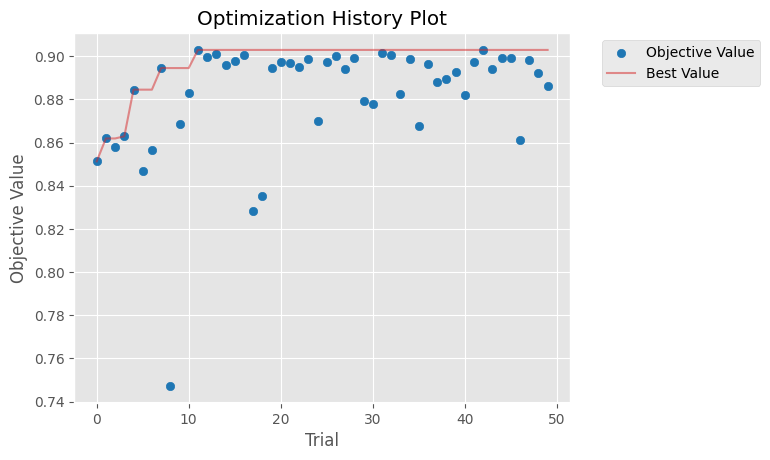

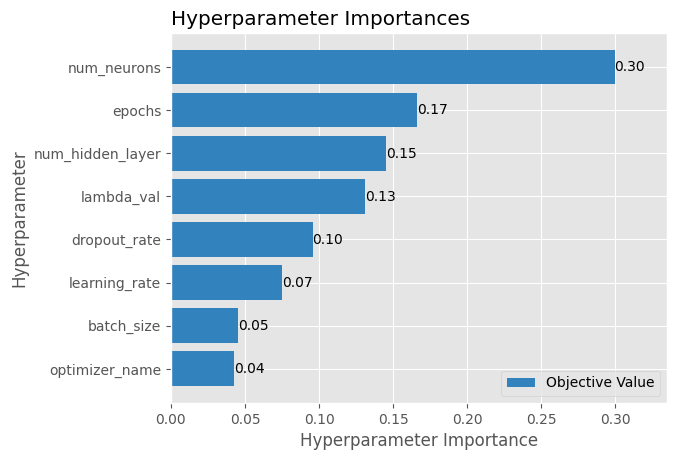

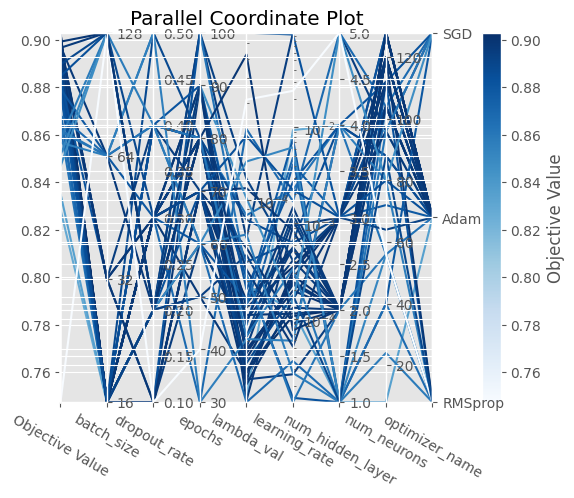

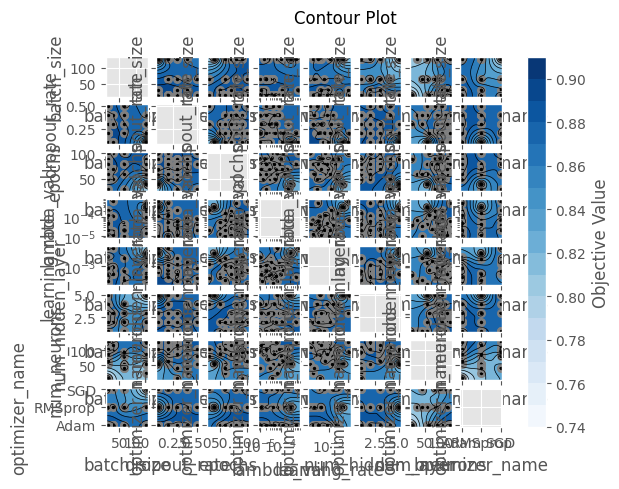

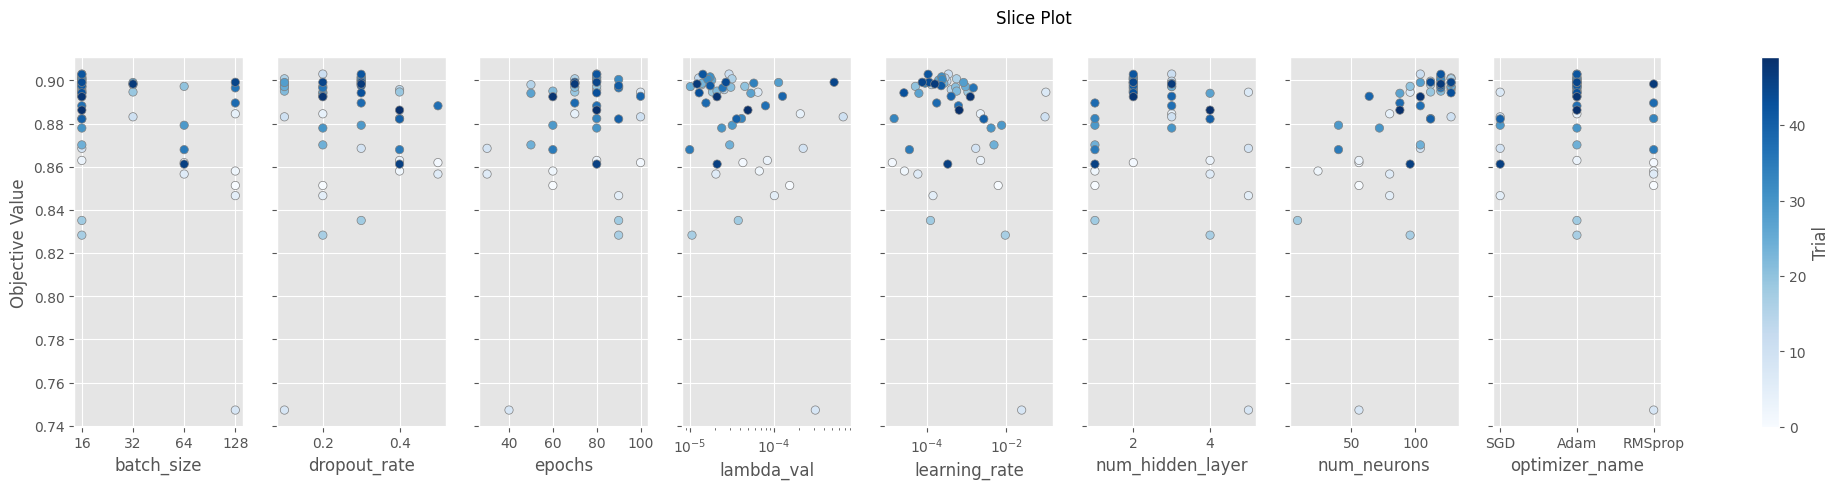

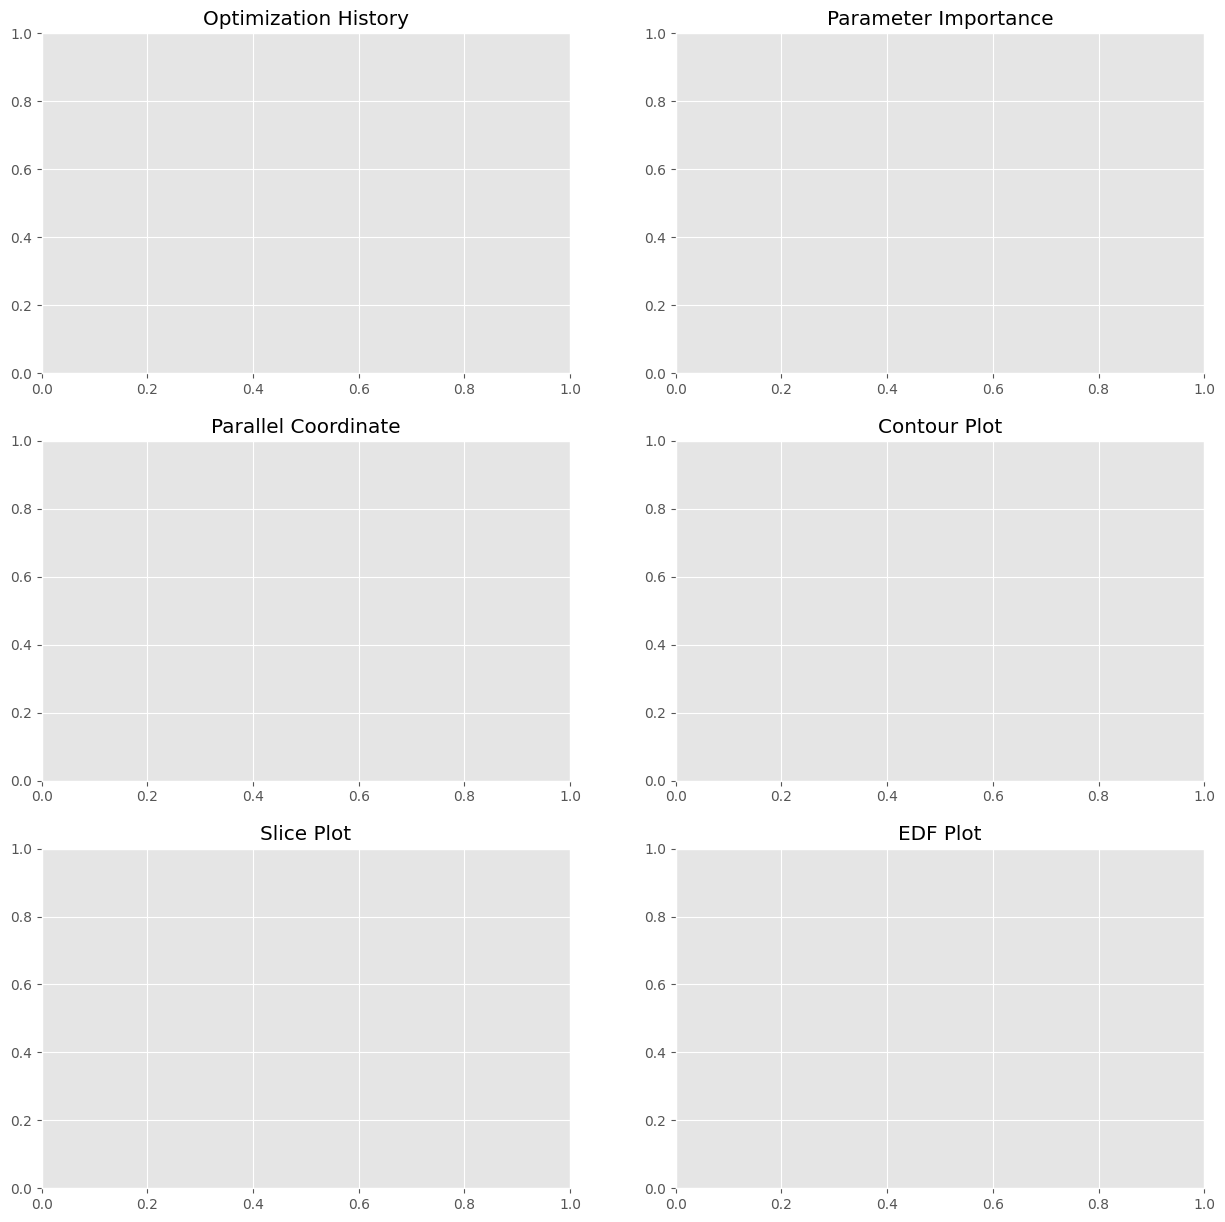

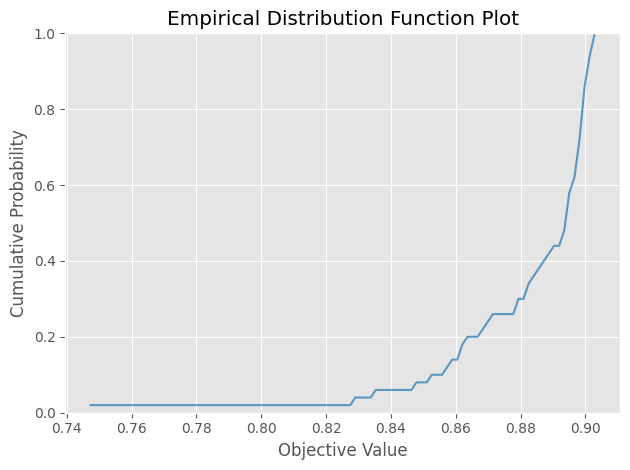

In [16]:
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_contour,
    plot_slice,
    plot_edf
)

# Layout: 3 rows × 2 columns, but contour will span both columns
fig = plt.figure(figsize=(14, 14))

# Axes grid spec
gs = fig.add_gridspec(3, 2)

# Top row
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Middle row
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Bottom row (contour spans both columns)
ax5 = fig.add_subplot(gs[2, :])

# Draw plots
plt.sca(ax1)
plot_optimization_history(study)
ax1.set_title("Optimization History")

plt.sca(ax2)
plot_param_importances(study)
ax2.set_title("Parameter Importance")

plt.sca(ax3)
plot_parallel_coordinate(study)
ax3.set_title("Parallel Coordinate")

plt.sca(ax4)
plot_slice(study)
ax4.set_title("Slice Plot")

plt.sca(ax5)
plot_contour(study)
ax5.set_title("Contour Plot (Larger)")

plt.tight_layout()
plt.show()
    